# Canonical form and serialisation

## Canonical task form

Under the hood, all Python, shell and workflow tasks generated by the
`pydra.compose.*.define` decorators/functions are translated to
[dataclass](https://docs.python.org/3/library/dataclasses.html)-like classes by the
[attrs](https://www.attrs.org/en/stable/) library. While the more compact syntax described
in the [Python-tasks](./4-python.html), [Shell-tasks](./5-shell.html) and [Workflow](./6-workflow.html)
tutorials is convenient when designing tasks for specific use cases, it is too magical
for linters follow. Therefore, when designing tasks to be used by third
parties (e.g. `pydra-fsl`, `pydra-ants`) it is recommended to favour the, more
explicit, "canonical" dataclass form.

The syntax of the canonical form is close to that used by the
[Attrs](https://www.attrs.org/en/stable/) package itself, with class type annotations
used to define the fields of the inputs and outputs of the task. Tasks defined in canonical
form will be able to be statically type-checked by [MyPy](https://mypy-lang.org/).

## Python-tasks

Python tasks in dataclass form are decorated by `pydra.compose.python.define`
with inputs listed as type annotations. Outputs are similarly defined in a nested class
called `Outputs`. The function to be executed should be a staticmethod called `function`.
Default values can also be set directly, as with Attrs classes.

In order to allow static type-checkers to check the type of outputs of tasks added
to workflows, it is also necessary to explicitly extend from the `pydra.compose.python.Task`
and `pydra.compose.python.Outputs` classes (they are otherwise set as bases by the
`define` method implicitly). Thus the "canonical form" of Python task is as
follows

In [1]:
from pydra.utils import print_help
from pydra.compose import python


@python.define
class CanonicalPythonTask(python.Task["CanonicalPythonTask.Outputs"]):
    """Canonical Python task class for testing

    Args:
        a: First input
            to be inputted
        b: Second input
    """

    a: int
    b: float = 2.0  # set default value

    class Outputs(python.Outputs):
        """
        Args:
            c: Sum of a and b
            d: Product of a and b
        """

        c: float
        d: float

    @staticmethod
    def function(a, b):
        return a + b, a / b


print_help(CanonicalPythonTask)

------------------------------------------
Help for Python task 'CanonicalPythonTask'
------------------------------------------

Inputs:
- b: float; default = 2.0
    Second input
- a: int
    First input to be inputted
- function: Callable[]; default = function()

Outputs:
- c: float
    Sum of a and b
- d: float
    Product of a and b



To set additional attributes other than the type and default, such as `allowed_values`
and `validators`, `python.arg` and `python.out` can be used instead.

In [2]:
import attrs.validators


@python.define
class CanonicalPythonTask(python.Task["CanonicalPythonTask.Outputs"]):
    """Canonical Python task class for testing

    Args:
        a: First input
            to be inputted
        b: Second input
    """

    a: int = python.arg(allowed_values=[1, 2, 3, 4, 5])
    b: float = python.arg(default=2.0, validator=attrs.validators.not_(0))

    class Outputs(python.Outputs):
        """
        Args:
            c: Sum of a and b
            d: Product of a and b
        """

        c: float
        d: float

    @staticmethod
    def function(a, b):
        return a + b, a / b


print_help(CanonicalPythonTask)

------------------------------------------
Help for Python task 'CanonicalPythonTask'
------------------------------------------

Inputs:
- a: int (allowed_values=frozenset({1, 2, 3, 4, 5}))
    First input to be inputted
- b: float; default = 2.0
    Second input
- function: Callable[]; default = function()

Outputs:
- c: float
    Sum of a and b
- d: float
    Product of a and b



## Shell-tasks

The canonical form of shell tasks is the same as for Python tasks, except a string `executable`
attribute replaces the `function` staticmethod.

In [3]:
import os
from pathlib import Path
from fileformats import generic
from pydra.compose import shell


# the "copied" output is magically passed to this function because the name matches
def get_file_size(copied: Path) -> int:
    """Calculate the file size"""
    result = os.stat(copied)
    return result.st_size


@shell.define
class CpFileWithSize(shell.Task["CpFileWithSize.Outputs"]):

    executable = "cp"

    in_file: generic.File  # = shell.arg() is assumed
    archive_mode: bool = shell.arg(argstr="-a", default=False)

    class Outputs(shell.Outputs):

        copied: generic.File = shell.outarg(
            position=-1, path_template="{in_file}_copied"
        )
        file_size: int = shell.out(callable=get_file_size)


print_help(CpFileWithSize)

------------------------------------
Help for Shell task 'CpFileWithSize'
------------------------------------

Inputs:
- executable: str | Sequence[str]; default = 'cp'
    the first part of the command, can be a string, e.g. 'ls', or a list, e.g.
    ['ls', '-l', 'dirname']
- archive_mode: bool; default = False ('-a')
- in_file: generic/file
- copied: Path | bool; default = True
    The path specified for the output file, if True, the default 'path
    template' will be used.
- append_args: list[str | generic/file]; default-factory = list()
    Additional free-form arguments to append to the end of the command.

Outputs:
- copied: generic/file
- file_size: int
- return_code: int
    The process' exit code.
- stderr: str
    The standard error stream produced by the command.
- stdout: str
    The standard output stream produced by the command.



## Workflow definitions

Workflows can also be defined in canonical form, which is the same as for Python tasks
but with a staticmethod called `constructor` that constructs the workflow.

----------------------------------------------
Help for Workflow task 'CanonicalWorkflowTask'
----------------------------------------------

Inputs:
- b: float
    A float input
- a: int
- constructor: Callable[]; default = constructor()

Outputs:
- out: float



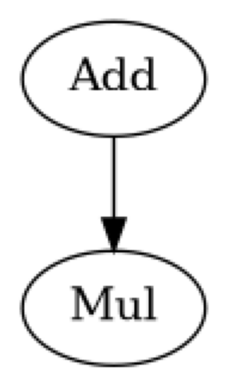

In [4]:
import typing as ty
import re
from pydra.compose import python, workflow
from pydra.utils import print_help, show_workflow


# Example python tasks
@python.define
def Add(a, b):
    return a + b


@python.define
def Mul(a, b):
    return a * b


@workflow.define
class CanonicalWorkflowTask(workflow.Task["CanonicalWorkflowTask.Outputs"]):

    @staticmethod
    def str2num(value: ty.Any) -> float | int:
        if isinstance(value, str) and re.match(r"^\d+(\.\d+)?$", value):
            return eval(value)  # use eval to convert string to number
        return value

    a: int
    b: float = workflow.arg(help="A float input", converter=str2num)

    @staticmethod
    def constructor(a, b):
        add = workflow.add(Add(a=a, b=b))
        mul = workflow.add(Mul(a=add.out, b=b))
        return mul.out

    class Outputs(workflow.Outputs):
        out: float


print_help(CanonicalWorkflowTask)
show_workflow(CanonicalWorkflowTask)

## Converting to/from dictionaries

As well as the dataclass-like canonical form, it is also possible to represent all tasks
in a nested dictionary form, which could be written to a static file (e.g. in JSON or
YAML format). The dictionary form of a class can be generated by the `pydra.utils.unstructure`
function. For example, the following shell command

In [5]:
MyCmd = shell.define(
    "my-cmd <in_file> <out|out_file> --an-arg <an_arg?> "
    "--a-flag<a_flag> --arg-with-default <arg_with_default:int=3>"
)

print_help(MyCmd)

----------------------------
Help for Shell task 'my_cmd'
----------------------------

Inputs:
- executable: str | Sequence[str]; default = 'my-cmd'
    the first part of the command, can be a string, e.g. 'ls', or a list, e.g.
    ['ls', '-l', 'dirname']
- in_file: generic/fs-object
- out_file: Path | bool; default = True
    The path specified for the output file, if True, the default 'path
    template' will be used.
- an_arg: str | None; default = None ('--an-arg')
- a_flag: bool; default = False ('--a-flag')
- arg_with_default: int; default = 3 ('--arg-with-default')
- append_args: list[str | generic/file]; default-factory = list()
    Additional free-form arguments to append to the end of the command.

Outputs:
- out_file: generic/fs-object
- return_code: int
    The process' exit code.
- stdout: str
    The standard output stream produced by the command.
- stderr: str
    The standard error stream produced by the command.



Can be converted into a serialised dictionary form

In [6]:
from pprint import pprint
from pydra.utils import unstructure

my_cmd_dict = unstructure(MyCmd)

pprint(my_cmd_dict)

{'executable': 'my-cmd',
 'inputs': {'a_flag': {'argstr': '--a-flag',
                       'default': False,
                       'position': 4,
                       'type': <class 'bool'>},
            'an_arg': {'argstr': '--an-arg',
                       'default': None,
                       'position': 3,
                       'type': str | None},
            'arg_with_default': {'argstr': '--arg-with-default',
                                 'default': 3,
                                 'position': 5,
                                 'type': <class 'int'>},
            'in_file': {'position': 1,
                        'type': <class 'fileformats.generic.fsobject.FsObject'>}},
 'name': 'my_cmd',
 'outputs': {'out_file': {'path_template': 'out_file',
                          'position': 2,
                          'type': <class 'fileformats.generic.fsobject.FsObject'>}},
 'type': 'shell',
 'xor': []}


Noting that there is still a little more work has to be done to serialise some Python
objects, e.g. classes used in field types and functions that are run in Python and
construct workflows in workflow tasks, before the serialized form can be written to JSON/YAML.

In [7]:
cp_with_size_dict = unstructure(CpFileWithSize)

pprint(cp_with_size_dict)

{'executable': 'cp',
 'inputs': {'archive_mode': {'argstr': '-a',
                             'default': False,
                             'position': 1,
                             'type': <class 'bool'>},
            'in_file': {'position': 2,
                        'type': <class 'fileformats.generic.file.File'>}},
 'name': 'CpFileWithSize',
 'outputs': {'copied': {'path_template': '{in_file}_copied',
                        'position': -1,
                        'type': <class 'fileformats.generic.file.File'>},
             'file_size': {'callable': <function get_file_size at 0x7f1cf409cd60>,
                           'type': <class 'int'>}},
 'type': 'shell',
 'xor': []}


To unserialize the general dictionary form back into a Task class, you can use the
`pydra.utils.structure` method

In [8]:
from pydra.utils import structure

ReloadedCpFileWithSize = structure(cp_with_size_dict)

which should run just as before

In [9]:
from pathlib import Path
import tempfile
from pydra.utils import asdict

tmp_dir = Path(tempfile.mkdtemp())

a_file = tmp_dir / "hello-world.txt"
a_file.write_text("Hello world")

cp_file_with_size = ReloadedCpFileWithSize(in_file=a_file)
outputs = cp_file_with_size(cache_root=tmp_dir / "cache")

pprint(asdict(outputs))

{'copied': File('/tmp/tmpffdho9rm/cache/shell-dbc412069e6d4570bbb2800582054f4c/hello-world_copied.txt'),
 'file_size': 11,
 'return_code': 0,
 'stderr': '',
 'stdout': ''}
